In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.ticker as ticker



In [2]:
data = "USA_cars_datasets.csv"

#This creates a duplicate of the data to allow it to be compared. This is the same as the data, but it includes values for all the years
testAccuracyData = data
#This colorMapping dictionary focuses on mapping a color to a category
#This is used in the getColor function when scanning for words and assigning them to a color
colorMapping = {
    'red': 'Red',
    'blue': 'Blue',
    'black': 'Black',
    'white': 'White',
    'silver': 'Silver',
    'gray': 'Gray',
    'grey': 'Gray',
}

In [3]:
def preprocess(csv_file):
    #Preprocesses the data by dropping null values, and only using the values for the Year and the Color
    data = pd.read_csv(csv_file)
    data = data.dropna()
    data = data[['year', 'color']]
    data = data.reset_index(drop=True)
    return data


In [4]:
def getColor(color):
    #Grabs the color and compares it with the color mapping dictionary
    #This function makes sure that values such as "Race Red" are marked under red by the colorMapping dictionary
    #It checks if a key word is in the color name and the dictionary and maps it to the color if it is
    for keyword, category in colorMapping.items():
        if keyword in color:
            return category
            #This returns the color "Other" which is for all colors not identified and for custom colors that are not made very often
    return colorMapping.get(color, "Other")

In [5]:
def getColorCounts(processedData):
    #Creates the dictionary in which data will be read from
    colorSale = defaultdict(lambda: defaultdict(int))

    #Loops through the data and counts how many sales of each color for each year
    for index, row in processedData.iterrows():
        year = row['year']
        color = row['color'].lower()
        colorCategory = getColor(color)
        colorSale[year][colorCategory] += 1
    return colorSale

In [6]:
def filterAndSortByYear(sales, minYear, maxYear):
    filteredData = defaultdict(lambda: defaultdict(int))

    for year, color_count in sorted(sales.items()):
        year = int(year)  #Convert year to an integer for comparison
        if minYear <= year <= maxYear:
            filteredData[year] = color_count

    return filteredData

In [7]:
def plotData(sales):
    #Creates a dataframe based on the data provided
    #This method is run twice, once for data exploration / this is the descriptive method
    #again to compare data predicted in this same format
    df = pd.DataFrame(sales).T

    sns.set_style("whitegrid")

    #This ensures that the colors on the bar graph align with their respective car colors they represent
    p = df.plot.bar(figsize=(12,8),color={'Red': 'red',
    'Blue': 'blue',
    'Black': 'black',
    'White': 'white',
    'Silver': 'silver',
    'Gray': 'gray',
    'Other': 'orange'}, width = 0.8)

    p.set_facecolor('lightgray')

    plt.title("Number of Cars Sold Per Year by Color")
    plt.xlabel("Year")
    plt.ylabel("Sales")
    plt.legend(title="Vehicle Color", loc='upper right')

    max_sales = df.values.max()
    y_ticks = np.arange(0, max_sales + 25, 25)
    plt.yticks(y_ticks)

    plt.show()


In [8]:
def predictSales(next_year, data1):
    color_sales = {}

    color_sales.update(data1)

    #Creates a Dataframe from the dictionary of data
    data1 = pd.DataFrame(color_sales).T.reset_index()
    data1.columns = ['Year'] + list(data1.columns[1:])

    s = {next_year : { }}
    color_sales.update(s)
    

    #Iterates over the colors and creates a linear regression chart for each color and prediction
    for color in data1.columns[1:]:
        
        #Creates a linear regression model // This is the non-descriptive method
        model = LinearRegression()

        #Fits the model with the data
        X = data1[['Year']]
        y = data1[color]

        model.fit(X, y)

        #Predicts the future sales based on the data
        predicted_sales = model.predict([[next_year]])

        #Stores the data into a dictionary that will be added to the main data dictionary for plotting in the future
        s[next_year] = {color : int(predicted_sales[0])}
        color_sales[next_year].update(s[next_year])


        #Creates a chart for the color it is currently on
        plt.figure(figsize=(6, 3))
        plt.scatter(X, y, color="black", label='Actual Sales')
        plt.plot(X, model.predict(X), color='red', label='Linear Regression')

        plt.plot([int(min(X['Year'])), next_year], [model.predict([[int(min(X['Year']))]])[0], model.predict([[next_year]])[0]], color='red')


        #Adds the prediction to the linear regression chart, ensuring that the point is shown and identifiable
        plt.scatter(next_year, int(predicted_sales[0]), color='red', marker='o', s=50, label='Predicted 2019 Sales')


        plt.title(f'Linear Regression for {color} Vehicle Sales')
        plt.xlabel('Year')
        plt.ylabel('Sales')
        plt.legend()

        plt.xticks(range(int(min(X['Year'])), int(max(X['Year']) + 2), 1))
        plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
        plt.show()

        predicted_sales[0] = int(predicted_sales[0])

        print(f"Predicted Sales for {next_year} for color {color}: {predicted_sales[0]}")
        data.update(color_sales)
    




In [9]:
def testAccuracy(predict, actual, year):
    #Stores the total MAE
    totalMAE = 0
    totalPercentage = 0

    #Loops through the sales in the actual data and the predicted data to compare
    for color, sales in actual[year].items():
        actual_value = [sales]
        predict_value = [predict[year][color]]
        mae = int(mean_absolute_error(actual_value, predict_value))
        print(f"MAE for {color} in {year}: {mae}")

        maxSales = max(actual[year].values())
        #Calculates the percentage of accuracy based on the MAE
        percentage = int((1 - mae / maxSales) * 100)
        print(f"{percentage}% Accurate")
        totalPercentage += percentage
        totalMAE += mae

    
    averagePercentage = totalPercentage / 7
    #Prints the accuracy values
    
    averageMAE = int(totalMAE / 7)
    print(f"Total Mean Absolue Error for year {year} is: {totalMAE}")
    print(f"Average Mean Absolue Error for year {year} is: {averageMAE}")
    print(f"Overall Accuracy is: {averagePercentage}%")

In [10]:
def plotPieChart(data, year):
    #This plots the pie chart
    colors = list(data[year].keys())
    sales = list(data[year].values())

    totalCount = sum(sales)

    section = ['blue', 'orange', 'silver', 'dimgray', 'white', 'red', 'gray']

    #This section allows for the piechart to include the sales amount and the sales percentage for the year
    fig = plt.figure(figsize=(6, 6))
    fig.patch.set_facecolor("lightgray")
    plt.pie(sales, labels=colors, autopct=lambda p: f'{p:.1f}% ({int(p * totalCount / 100)})', startangle=140, colors=section)
    plt.title(f'Sales Distribution  By Color for {year}')
    plt.axis('equal')

    fig.text(0, 0, f'Total Amount of Cars: {totalCount}', fontsize=12, color='black', ha='center', va='center')
    plt.show()

Which year would you like to predict sales for:? (2018-2019) 2019
Would you like to see how accurate the model on its prediction based on the actual data?(Y/N): n


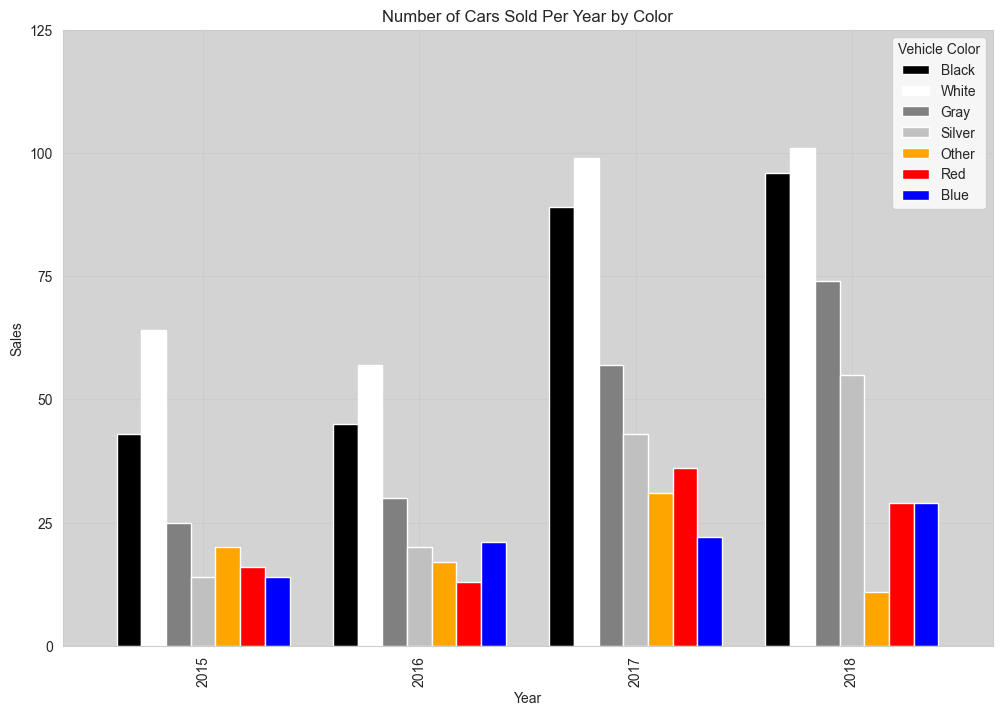

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


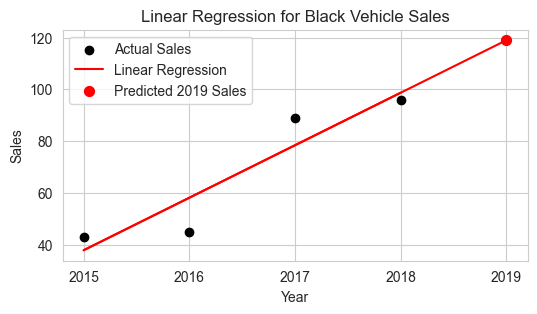

Predicted Sales for 2019 for color Black: 119.0


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


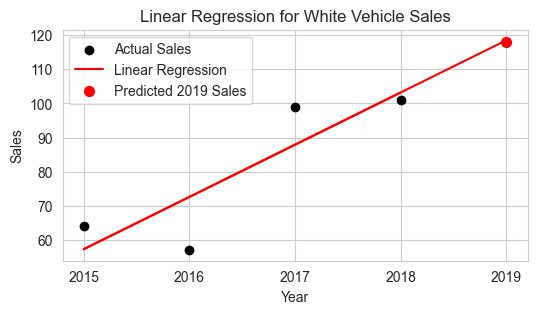

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Predicted Sales for 2019 for color White: 118.0


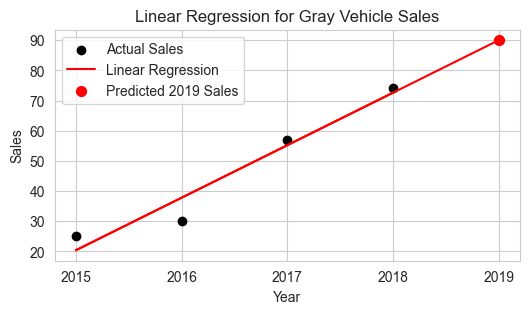

Predicted Sales for 2019 for color Gray: 90.0


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


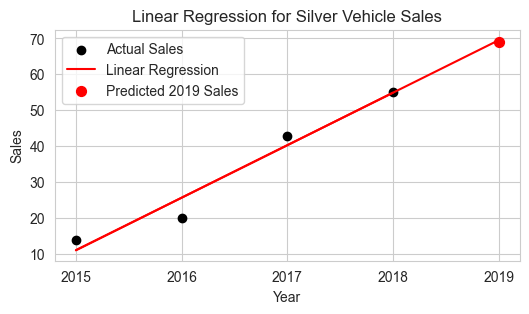

Predicted Sales for 2019 for color Silver: 69.0


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


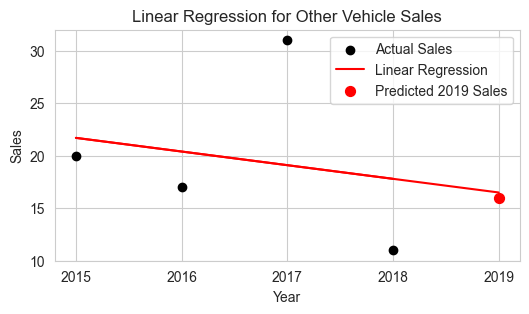

Predicted Sales for 2019 for color Other: 16.0


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


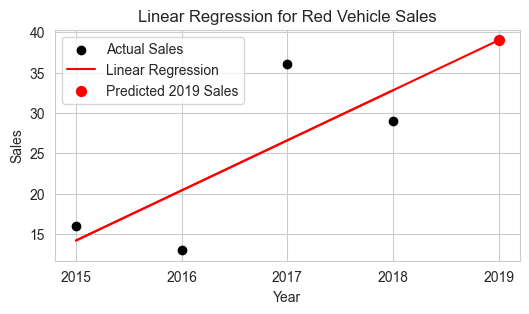

Predicted Sales for 2019 for color Red: 39.0


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


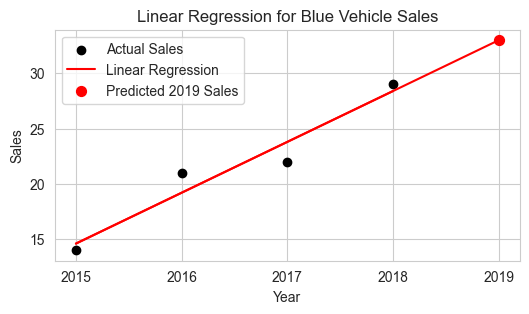

Predicted Sales for 2019 for color Blue: 33.0


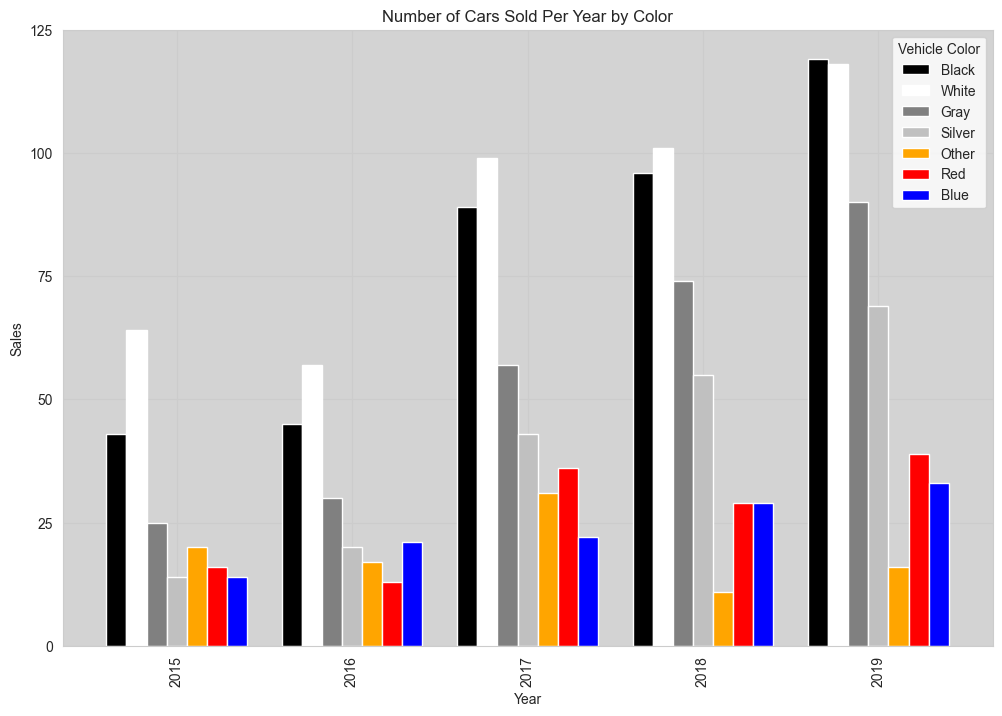

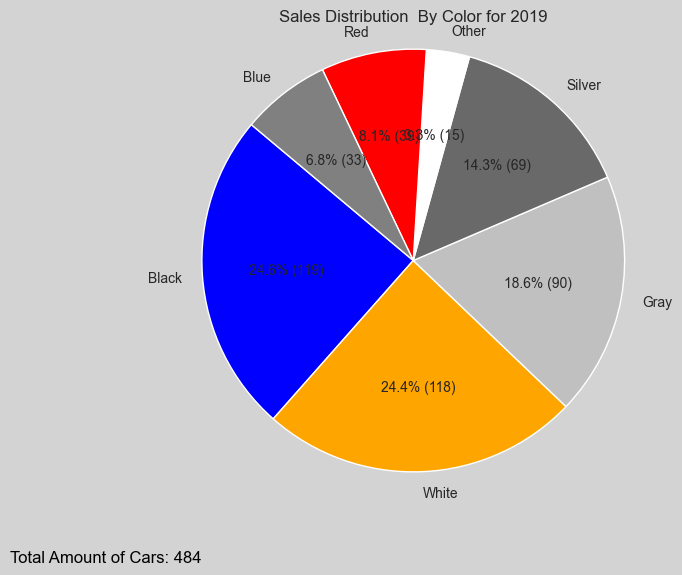

In [11]:
userIn = input("Which year would you like to predict sales for:? (2018-2019)")
predictYear = int(userIn)
if predictYear >= 2018:
    userIn2 = input("Would you like to see how accurate the model on its prediction based on the actual data?(Y/N):")

data = preprocess(data)
data = getColorCounts(data)
if predictYear >= 2019:
    data = filterAndSortByYear(data, 2015, 2018)
else:
    data = filterAndSortByYear(data, 2014, 2017)
plotData(data)
predictSales(int(predictYear), data)
plotData(data)
plotPieChart(data, predictYear)
if userIn2.lower() == 'y':
    testAccuracyData = preprocess(testAccuracyData)
    testAccuracyData = getColorCounts(testAccuracyData)
    testAccuracy(data,testAccuracyData,predictYear)
